# Retesting Julia's method for Panan005

In [1]:
import dask.distributed as dsk
import glob
import intake
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/45553/status,
Dashboard: /proxy/45553/status,Workers: 28
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33905,Workers: 28
Dashboard: /proxy/45553/status,Total threads: 28
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:32931,Total threads: 1
Dashboard: /proxy/34049/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:45583,


In [4]:
pathsC = np.sort(glob.glob('/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ocean_month_z.nc'))[-66:]
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/*/*.ocean_month_z.nc'))

In [5]:
pathsC

array(['/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output024/20010101.ocean_month_z.nc',
       '/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output025/20010301.ocean_month_z.nc',
       '/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output026/20010501.ocean_month_z.nc',
       '/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output027/20010701.ocean_month_z.nc',
       '/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output028/20010901.ocean_month_z.nc',
       '/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output029/20011101.ocean_month_z.nc',
       '/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output030/20020101.ocean_month_z.nc',
       '/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output031/20020301.ocean_month_z.nc',
       '/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output032/20020501.ocean_month_z.nc',
       '/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr

In [5]:
shelf_mask = shelf_mask = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc')['contour_masked_above']

In [6]:
areaC = xr.open_dataset('/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['areacello'].sel(xh=shelf_mask['xh'])
areaM = xr.open_dataset('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/output020/20010101.ocean_static.nc')['areacello'].sel(xh=shelf_mask['xh'])

In [7]:
def preprocess(ds):
    ds = ds[['thetao', 'volcello']].sel(yh=shelf_mask['yh'], z_l=slice(None,500))
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [8]:
tempC = cont['thetao']
volcC = cont['volcello']
thikC = cont['volcello']/areaC

In [9]:
thikC

<xarray.DataArray (time: 132, z_l: 39, yh: 533, xh: 3600)> Size: 40GB
dask.array<truediv, shape=(132, 39, 533, 3600), dtype=float32, chunksize=(2, 22, 211, 1030), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 4kB -79.0 -78.95 -78.91 ... -55.18 -55.12 -55.07
  * z_l      (z_l) float64 312B 0.5413 1.681 2.94 4.332 ... 383.0 423.7 468.4
  * time     (time) object 1kB 2001-01-16 12:00:00 ... 2011-12-16 12:00:00

In [9]:
tempM = melt['thetao']
volcM = melt['volcello']
thikM = melt['volcello']/areaM

In [10]:
temp_500_C = tempC.weighted(thikC.fillna(0)).mean('z_l').where(shelf_mask == 0).weighted(areaC.fillna(0)).mean(['xh', 'yh'])
temp_500_M = tempM.weighted(thikM.fillna(0)).mean('z_l').where(shelf_mask == 0).weighted(areaM.fillna(0)).mean(['xh', 'yh'])

In [11]:
temp_500_C = temp_500_C.load()

In [12]:
temp_500_M = temp_500_M.load()

Text(0.5, 1.0, 'Panan01 Time Series of Temperature for shelf top 500m')

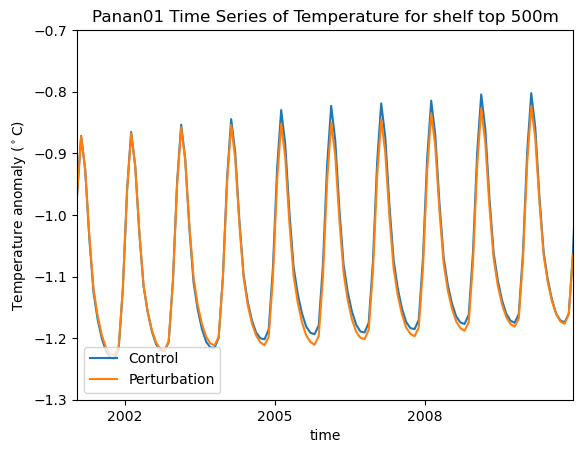

In [14]:
temp_500_C.plot(label="Control")
temp_500_M.plot(label="Perturbation")
plt.xlim(380,4000)
plt.ylim(-1.30,-0.70)
plt.ylabel("Temperature anomaly ($^\circ$C)")
plt.legend(loc="lower left")
plt.title("Panan01 Time Series of Temperature for shelf top 500m")

## Mapping

In [15]:
tempcont_500 = tempC.sel(z_l=slice(0,500)).weighted(thikC['z_l'].fillna(0)).mean(dim='z_l').mean(dim='time')
temppert_500 = tempM.sel(z_l=slice(0,500)).weighted(thikM['z_l'].fillna(0)).mean(dim='z_l').mean(dim='time')
tempanom_500 = temppert_500 - tempcont_500

In [16]:
tempanom_500 = tempanom_500.load()

In [18]:
import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

In [19]:
depth = xr.open_dataset('/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho']
land_mask = (0 * depth).fillna(1)
land_50m = cft.NaturalEarthFeature("physical", "land", "50m", edgecolor="black", facecolor="papayawhip", linewidth=0.5)
projection = ccrs.SouthPolarStereo()

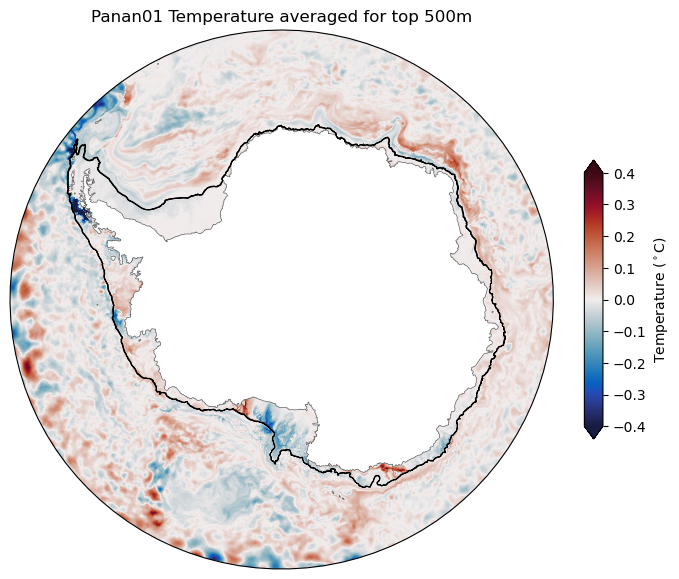

In [20]:
plt.figure(figsize=(8, 7))
ax = plt.axes(projection=projection)

ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary for the map. 
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.5,transform = ccrs.PlateCarree())

tempanom_500.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-0.4,
    vmax=0.4,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Temperature ($^\circ$C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("Panan01 Temperature averaged for top 500m");

## Saving

In [26]:
# Note - was saved wrong initially but has since been renamed to fix.
temp_500_C.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan01_temp_C_500time.nc')
temp_500_M.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan01_temp_M_500time.nc')

In [19]:
temppert_005 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan005_temp_M_500time.nc', chunks = 'auto')
tempcont_005 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan005_temp_C_500time.nc', chunks = 'auto')
temppert_01 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan01_temp_M_500time.nc', chunks = 'auto')
tempcont_01 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan01_temp_C_500time.nc', chunks = 'auto')

In [20]:
tempanom_005 = temppert_005 - tempcont_005
tempanom_005 = tempanom_005.load()

In [21]:
tempanom_01 = temppert_01 - tempcont_01
tempanom_01 = tempanom_01.load()

Text(0.5, 1.0, 'Time Series of temperature anomaly for shelf top 500m')

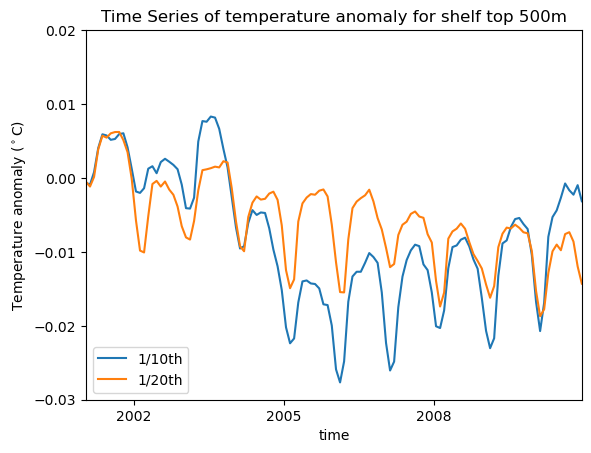

In [23]:
tempanom_01.plot(label="1/10th")
tempanom_005.plot(label="1/20th")
plt.xlim(380,4000)
plt.ylim(-0.03,0.02)
plt.ylabel("Temperature anomaly ($^\circ$C)")
plt.legend(loc="lower left")
plt.title("Time Series of temperature anomaly for shelf top 500m")

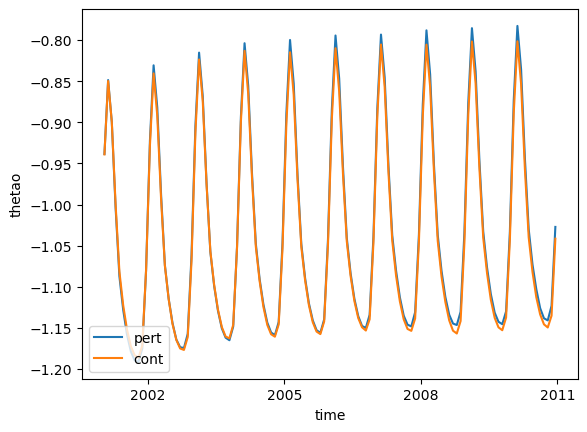

In [18]:
temppert_005.plot(label="pert")
tempcont_005.plot(label="cont")

plt.legend(loc="lower left")